## Single Spectrum-sp500logreturn-daily

In [9]:
import numpy as np
np.random.seed(30821)
import pandas as pd

import cv2
import os
from PIL import Image
import keras

In [18]:
os.environ['KERAS_BACKEND']='tensorflow'
SIZE=64
CMO_directory='/Users/luzhang/Desktop/CMO_spectrum/'
DPO_directory='/Users/luzhang/Desktop/DPO_spectrum/'
CMO_dataset=[]
DPO_dataset=[]
label=[]

In [19]:
up_CMO=os.listdir(CMO_directory+'upspectrum/')
for i, image_name in enumerate(up_CMO):
        if(image_name.split('.')[1]=='png'):
                image=cv2.imread(CMO_directory+'upspectrum/'+image_name)
                image=Image.fromarray(image, 'RGB')
                image=image.resize((SIZE, SIZE))
                CMO_dataset.append(np.array(image))
                label.append(1)
                
down_CMO=os.listdir(CMO_directory+'downspectrum/')
for i, image_name in enumerate(down_CMO):
        if(image_name.split('.')[1]=='png'):
                image=cv2.imread(CMO_directory+'downspectrum/'+image_name)
                image=Image.fromarray(image, 'RGB')
                image=image.resize((SIZE, SIZE))
                CMO_dataset.append(np.array(image))
                label.append(0)

In [20]:
up_DPO=os.listdir(DPO_directory+'upspectrum/')
for i, image_name in enumerate(up_DPO):
        if(image_name.split('.')[1]=='png'):
                image=cv2.imread(DPO_directory+'upspectrum/'+image_name)
                image=Image.fromarray(image, 'RGB')
                image=image.resize((SIZE, SIZE))
                DPO_dataset.append(np.array(image))
                
down_DPO=os.listdir(DPO_directory+'downspectrum/')
for i, image_name in enumerate(down_DPO):
        if(image_name.split('.')[1]=='png'):
                image=cv2.imread(DPO_directory+'downspectrum/'+image_name)
                image=Image.fromarray(image, 'RGB')
                image=image.resize((SIZE, SIZE))
                DPO_dataset.append(np.array(image))

In [25]:
dataset=[]
dataset=np.stack((CMO_dataset, DPO_dataset), axis=1)

In [26]:
print(len(CMO_dataset))
print(len(DPO_dataset))
print(type(CMO_dataset))
print(type(DPO_dataset))

3068
3068
<class 'list'>
<class 'list'>


In [23]:
INPUT_SHAPE=(SIZE,SIZE,3)# change to (SIZE, SIZE, 3)
inp=keras.layers.Input(shape=INPUT_SHAPE)

conv1=keras.layers.Conv2D(32, kernel_size=(3,3),
                          activation='relu',padding='same')(inp)
pool1=keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
norm1=keras.layers.BatchNormalization(axis=-1)(pool1)
drop1=keras.layers.Dropout(rate=0.2)(norm1)

conv2=keras.layers.Conv2D(32, kernel_size=(3,3),
                          activation='relu',padding='same')(drop1)
pool2=keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
norm2=keras.layers.BatchNormalization(axis=-1)(pool2)
drop2=keras.layers.Dropout(rate=0.2)(norm2)

flat=keras.layers.Flatten()(drop2) # Flatten the matrix to get it ready for density

hidden1=keras.layers.Dense(512, activation='relu')(flat)
norm3=keras.layers.BatchNormalization(axis=-1)(hidden1)
drop3=keras.layers.Dropout(rate=0.2)(norm3)

hidden2=keras.layers.Dense(256, activation='relu')(drop3)
norm4=keras.layers.BatchNormalization(axis=-1)(hidden2)
drop4=keras.layers.Dropout(rate=0.2)(norm4)

out=keras.layers.Dense(2,activation='sigmoid')(drop4) # units=1 gives errors

model=keras.Model(inputs=inp, outputs=out)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',# Check between binary_crossent
              metrics=['accuracy'])

print(model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0   

In [29]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test=train_test_split(dataset, to_categorical(np.array(label)), test_size=0.2, random_state=0)

history=model.fit(np.array(X_train), y_train, batch_size=64, verbose=1, epochs=50,validation_split=0.1, shuffle=False)


Epoch 1/50


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [6]:
print("Test_Accuracy: {:.22f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

20/20 [==============================] - 0s 14ms/step - loss: 1.7171 - accuracy: 0.5961
Test_Accuracy: 59.6091210842132568359375%


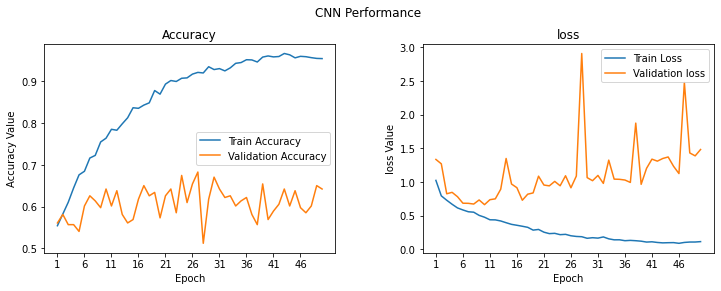

In [7]:
import matplotlib.pyplot as plt
f, (ax1, ax2) =plt.subplots(1,2,figsize=(12,4))
t=f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch=len(history.history['accuracy'])+1
epoch_list=list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label="Validation Accuracy")
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1=ax1.legend(loc='best')

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label="Validation loss")
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('loss')
l2=ax2.legend(loc='best')

model.save("CMO_attempt_CNN.h5")


## Dual-input DVI, DPO

In [8]:
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [ ]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(128, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.4)(model)
    
  return model

In [ ]:

current_input = Input(shape=input_shape)
current_model = create_convolution_layers(current_input)

voltage_input = Input(shape=input_shape)
voltage_model = create_convolution_layers(voltage_input)

conv = concatenate([current_model, voltage_model])

conv = Flatten()(conv)

dense = Dense(512)(conv)
dense = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[current_input, voltage_input], outputs=[output])

opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])